# Задание 5.1 - Word2Vec

В этом задании мы натренируем свои word vectors на очень небольшом датасете.
Мы будем использовать самую простую версию word2vec, без negative sampling и других оптимизаций.

Перед запуском нужно запустить скрипт `download_data.sh` чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline

In [2]:
device = torch.device("cuda:0")

In [6]:
!wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
!unzip stanfordSentimentTreebank.zip

--2021-05-14 17:21:01--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2021-05-14 17:21:01--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip’

stanfordSentimentTr 100%[===================>]   6.08M  7.41MB/s    in 0.8s    

2021-05-14 17:21:02 (7.41 MB/s) - ‘stanfordSentimentTreebank.zip’ saved [6372817/6372817]

Archive:  stanfordSentimentTreebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
   creating: 

In [7]:
import os
import numpy as np

class StanfordTreeBank:
    def __init__(self):
        self.index_by_token = {}
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper:
        # https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before + words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(1):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
chance ['larky', 'emotionally']


# Имплеменируем PyTorch-style Dataset для Word2Vec

Этот Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Напоминаем, что word2vec модель получает на вход One-hot вектор слова и тренирует простую сеть для предсказания на его основе соседних слов.
Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте):

Например:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `love`
- input: `orders`, target: `nicest`
- input: `orders`, target: `to`
- input: `orders`, target: `50-year`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [8]:
class Word2VecPlain(Dataset):
    def __init__(self, data, num_contexts=30000):
        self.data = data
        self.samples = None
        self.num_contexts = num_contexts
        self.num_tokens = len(self.data.index_by_token)
    
    def generate_dataset(self, context_length=5):
        self.samples = []
        for i in range(self.num_contexts):
            center_word, other_words = self.data.get_random_context(context_length)
            for word in other_words:
                self.samples.append((self.data.index_by_token[center_word], self.data.index_by_token[word]))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        input, output_index = self.samples[index]
        input_vector = torch.zeros(self.num_tokens)
        input_vector[input] = 1.0
        return input_vector, output_index  

dataset = Word2VecPlain(data, 10)
dataset.generate_dataset()
input_vector, target = dataset[3]
print("Sample - input: %s, target: %s" % (input_vector, int(target))) # target should be able to convert to int
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
assert input_vector.shape[0] == data.num_tokens()

Sample - input: tensor([0., 0., 0.,  ..., 0., 0., 0.]), target: 2835


# Создаем модель и тренируем ее

In [9]:
# Create the usual PyTorch structures
dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()

# We'll be training very small word vectors!
wordvec_dim = 10

# We can use a standard sequential model for this
nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
nn_model.type(torch.FloatTensor)

Sequential(
  (0): Linear(in_features=19538, out_features=10, bias=False)
  (1): Linear(in_features=10, out_features=19538, bias=False)
)

In [10]:
def extract_word_vectors(nn_model):
    input_vectors, output_vectors = nn_model[0].weight.T, nn_model[1].weight
    return torch.clone(input_vectors), torch.clone(output_vectors)

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [12]:
def train_model(model, dataset, train_loader, optimizer, scheduler, num_epochs):
    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct = 0
        total = 0
        for i_step, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)

            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct += torch.sum(indices == y)
            total += y.shape[0]
            
            loss_accum += loss_value
        
        scheduler.step()

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct) / total
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)

        dataset.generate_dataset() # Regenerate dataset every epoch
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **8.0**.

In [42]:
nn_model = nn_model.to(device)

optimizer = optim.SGD(nn_model.parameters(), lr=2e0, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.9)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=10)

loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 20)

Epoch 0, Average loss: 8.366673, Train accuracy: 0.017563
Epoch 1, Average loss: 8.341625, Train accuracy: 0.025230
Epoch 2, Average loss: 8.190517, Train accuracy: 0.026744
Epoch 3, Average loss: 8.150561, Train accuracy: 0.026868
Epoch 4, Average loss: 8.115022, Train accuracy: 0.028085
Epoch 5, Average loss: 8.085549, Train accuracy: 0.027671
Epoch 6, Average loss: 8.085678, Train accuracy: 0.028053
Epoch 7, Average loss: 8.060396, Train accuracy: 0.028128
Epoch 8, Average loss: 8.016408, Train accuracy: 0.030843
Epoch 9, Average loss: 8.017492, Train accuracy: 0.029206
Epoch 10, Average loss: 8.012906, Train accuracy: 0.030018
Epoch 11, Average loss: 7.977706, Train accuracy: 0.029977
Epoch 12, Average loss: 7.954415, Train accuracy: 0.032252
Epoch 13, Average loss: 7.935310, Train accuracy: 0.033334
Epoch 14, Average loss: 7.937032, Train accuracy: 0.032330
Epoch 15, Average loss: 7.924097, Train accuracy: 0.032492
Epoch 16, Average loss: 7.901945, Train accuracy: 0.034290
Epoch 1

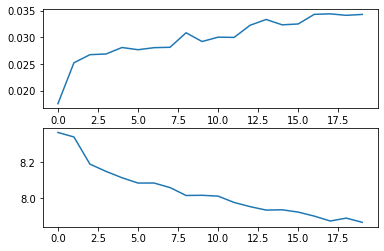

In [45]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)
plt.show()

# Визуализируем вектора для разного вида слов до и после тренировки

В случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных) разделяются семантически.

Студенты - в качестве выполненного задания присылайте notebook с диаграммами!

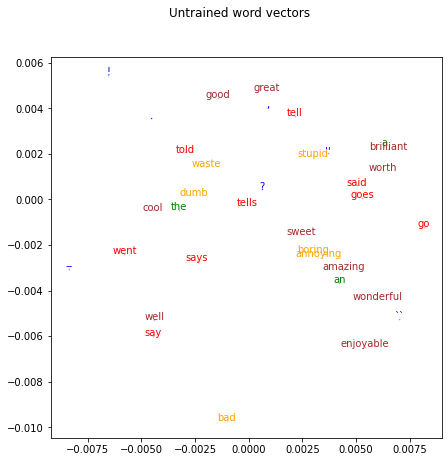

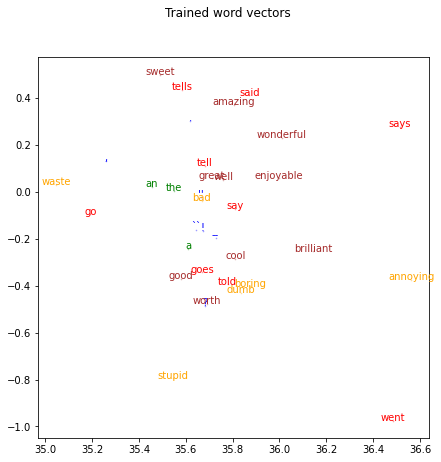

In [46]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors.detach().numpy())

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors.cpu(), untrained_output_vectors.cpu(), "Untrained word vectors")
visualize_vectors(trained_input_vectors.cpu(), trained_output_vectors.cpu(), "Trained word vectors")